In [1]:
import urllib

download_path = "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"
data = urllib.request.urlopen(download_path)

text_chars = ""

whitespace_replace_chars = ["\\n"]
remove_chars = ["'", '"', "-", ",", ":", "?", "!", ";"]

for line in data:
    line = str(line).lower()[2:]
    for replace_char in whitespace_replace_chars:
        line = line.replace(replace_char, " ")
    for remove_char in remove_chars:
        line = line.replace(remove_char, "")
    text_chars += line
text_chars = ' '.join(text_chars.split())

In [2]:
print(text_chars[:2000])

first citizen before we proceed any further hear me speak. all speak speak. first citizen you are all resolved rather to die than to famish all resolved. resolved. first citizen first you know caius marcius is chief enemy to the people. all we knowt we knowt. first citizen let us kill him and well have corn at our own price. ist a verdict all no more talking ont let it be done away away second citizen one word good citizens. first citizen we are accounted poor citizens the patricians good. what authority surfeits on would relieve us if they would yield us but the superfluity while it were wholesome we might guess they relieved us humanely but they think we are too dear the leanness that afflicts us the object of our misery is as an inventory to particularise their abundance our sufferance is a gain to them let us revenge this with our pikes ere we become rakes for the gods know i speak this in hunger for bread not in thirst for revenge. second citizen would you proceed especially again

In [3]:
print(len(text_chars))

1061639


In [4]:
import torch

def batches(data, batch_size=32):
    l = len(data)
    for i in range(0, l, batch_size):
        yield data[i:min(i + batch_size, l)]

def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

def letter_to_tensor(letter):
    letter_tensor = torch.zeros(1, N_LETTERS)
    letter_tensor[0][letter_to_index(letter)] = 1
    return letter_tensor

def line_to_tensor(line):
    line_tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        line_tensor[i][0][letter_to_index(letter)] = 1
    return line_tensor

In [5]:
import string

ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

print(line_to_tensor(text_chars[:10]).shape) # torch.Size([10, 1, 57]) = BATCH_SIZE x 1 x N_LETTERS

data_lines = []
for batch in batches(text_chars, batch_size=16):
    data_lines.append(batch)

torch.Size([10, 1, 57])


In [6]:
print(line_to_tensor(data_lines[54]).shape)

torch.Size([16, 1, 57])


In [7]:
import glob
import unicodedata

def find_file_names(file_path_string):
    return glob.glob(file_path_string)

def to_ascii(string):
    return "".join(char for char in unicodedata.normalize("NFD", string)
                  if unicodedata.category(char) != "Mn"
                  and char in ALL_LETTERS)

def read_lines(file):
    data = open(file, encoding='utf-8').read().strip().split('\n')
    return [to_ascii(line) for line in data]

In [8]:
names_data_files = "../data/names_data/names/*.txt"

print(find_file_names(names_data_files))

['../data/names_data/names/Scottish.txt', '../data/names_data/names/French.txt', '../data/names_data/names/Dutch.txt', '../data/names_data/names/Czech.txt', '../data/names_data/names/Irish.txt', '../data/names_data/names/Greek.txt', '../data/names_data/names/Italian.txt', '../data/names_data/names/Russian.txt', '../data/names_data/names/Japanese.txt', '../data/names_data/names/Arabic.txt', '../data/names_data/names/German.txt', '../data/names_data/names/Korean.txt', '../data/names_data/names/Polish.txt', '../data/names_data/names/Spanish.txt', '../data/names_data/names/Vietnamese.txt', '../data/names_data/names/Chinese.txt', '../data/names_data/names/Portuguese.txt', '../data/names_data/names/English.txt']


In [9]:
import os 

data_dict = {}
categories_list = []

for file in find_file_names(names_data_files):
    name_category = os.path.splitext(os.path.basename(file))[0]
    categories_list.append(name_category)
    lines = read_lines(file)
    data_dict[name_category] = lines
    
N_CATEGORIES = len(data_dict)

In [10]:
print(data_dict.keys())
print(data_dict["Scottish"][:10])

dict_keys(['Scottish', 'French', 'Dutch', 'Czech', 'Irish', 'Greek', 'Italian', 'Russian', 'Japanese', 'Arabic', 'German', 'Korean', 'Polish', 'Spanish', 'Vietnamese', 'Chinese', 'Portuguese', 'English'])
['Smith', 'Brown', 'Wilson', 'Campbell', 'Stewart', 'Thomson', 'Robertson', 'Anderson', 'Macdonald', 'Scott']


In [12]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [14]:
N_HIDDEN = 128
rnn = RNN(N_LETTERS, N_HIDDEN, N_CATEGORIES)

In [20]:
import random

# category_lines = {} = data_dict
# all_categories = [] = categories_list

def category_from_output(output):
    """
    Computes the category given an output tensor from the model
    """
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return categories_list[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(categories_list)
    line = randomChoice(data_dict[category])
    category_tensor = torch.tensor([categories_list.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Scottish / line = Watson
category = Dutch / line = Buiren
category = Russian / line = Hamitski
category = Czech / line = Zitka
category = Czech / line = Sedmikova
category = Vietnamese / line = Phi
category = Russian / line = Jitluhin
category = Russian / line = Velsh
category = Japanese / line = Tsunoda
category = Vietnamese / line = Cao


In [21]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [22]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.4109 Moon / Chinese ✗ (Korean)
10000 10% (0m 11s) 3.5226 Morcos / Greek ✗ (Arabic)
15000 15% (0m 15s) 2.5475 Von brandt / French ✗ (German)
20000 20% (0m 20s) 1.9441 Morales / Portuguese ✗ (Spanish)
25000 25% (0m 24s) 0.9571 Kokoris / Greek ✓
30000 30% (0m 29s) 2.4060 Achterberg / French ✗ (German)
35000 35% (0m 33s) 2.5013 Naoimhin / Russian ✗ (Irish)
40000 40% (0m 37s) 0.8175 Ryoo / Korean ✓
45000 45% (0m 42s) 1.5339 Rickett / English ✓
50000 50% (0m 47s) 1.0458 Gomes / Portuguese ✓
55000 55% (0m 52s) 2.1144 Sai / Chinese ✗ (Vietnamese)
60000 60% (0m 57s) 0.8230 Gonzalez / Spanish ✓
65000 65% (1m 2s) 0.8113 An / Vietnamese ✓
70000 70% (1m 8s) 2.4400 Bureau / Arabic ✗ (French)
75000 75% (1m 12s) 0.5202 Corraidhin / Irish ✓
80000 80% (1m 17s) 0.2575 Yau / Chinese ✓
85000 85% (1m 21s) 0.0653 Totolos / Greek ✓
90000 90% (1m 26s) 1.2326 Flores / Portuguese ✗ (Spanish)
95000 95% (1m 30s) 0.2290 Parri / Italian ✓
100000 100% (1m 35s) 1.4262 Pae / Vietnamese ✗ (Korean)


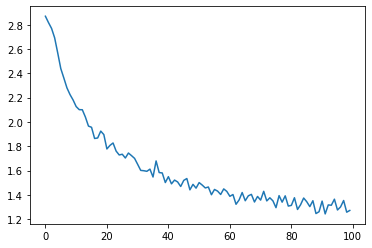

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-27-4b604e00780c>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + categories_list, rotation=90)
<ipython-input-27-4b604e00780c>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + categories_list)


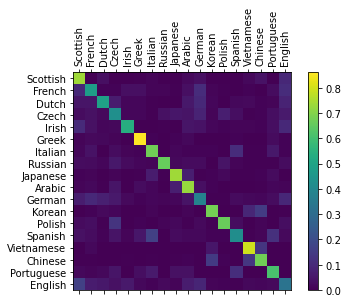

In [27]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(N_CATEGORIES, N_CATEGORIES)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = categories_list.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(N_CATEGORIES):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + categories_list, rotation=90)
ax.set_yticklabels([''] + categories_list)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [29]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, categories_list[category_index]))
            predictions.append([value, categories_list[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.56) Czech
(-1.25) Russian
(-2.58) English

> Jackson
(-0.27) Scottish
(-1.87) English
(-3.30) Russian

> Satoshi
(-1.05) Italian
(-1.57) Polish
(-2.44) Arabic
